In [ ]:
#| include: false
from wxbs_benchmark.dataset import *
from wxbs_benchmark.metrics import *
from wxbs_benchmark.evaluation import *

## Install

`pip install wxbs_benchmark`

## How to use

## Task 1: fundamental matrix estimation

I will show you 
how to benchmark a simple baseline of OpenCV SIFT + MAGSAC++ below.

In [ ]:
import numpy as np
import cv2
import kornia.feature as KF
import torch
from kornia_moons.feature import *
from tqdm import tqdm
from wxbs_benchmark.dataset import *
from wxbs_benchmark.evaluation import *
import matplotlib.pyplot as plt


def estimate_F_SIFT(img1, img2):
    det = cv2.SIFT_create(8000, contrastThreshold=-10000, edgeThreshold=10000)
    kps1, descs1 = det.detectAndCompute(img1, None)
    kps2, descs2 = det.detectAndCompute(img2, None)
    snn_ratio, idxs = KF.match_snn(torch.from_numpy(descs1),
                           torch.from_numpy(descs2), 0.9)
    tentatives = cv2_matches_from_kornia(snn_ratio, idxs)
    src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
    dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
    F, _ = cv2.findFundamentalMat(src_pts, dst_pts, cv2.USAC_MAGSAC, 0.25, 0.999, 100000)
    return F


Fs = []
subset = 'test'
dset = WxBSDataset('.WxBS', subset=subset, download=True)
for pair_dict in tqdm(dset):
    Fs.append(estimate_F_SIFT(pair_dict['img1'],
                         pair_dict['img2']))
result_dict, thresholds = evaluate_Fs(Fs, subset)

100%|███████████████████████████████████████████| 32/32 [00:11<00:00,  2.67it/s]


<matplotlib.legend.Legend>

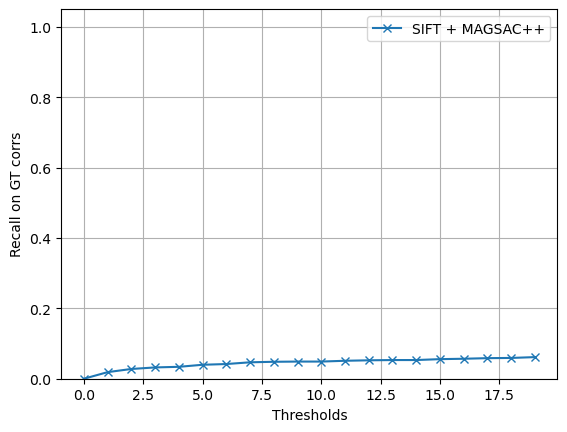

In [ ]:

plt.figure()
plt.plot(thresholds, result_dict['average'], '-x')
plt.ylim([0,1.05])
plt.xlabel('Thresholds')
plt.ylabel('Recall on GT corrs')
plt.grid(True)
plt.legend(['SIFT + MAGSAC++'])

We can also check per-image-pair results

/opt/homebrew/Caskroom/miniforge/base/envs/python39/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<matplotlib.legend.Legend>

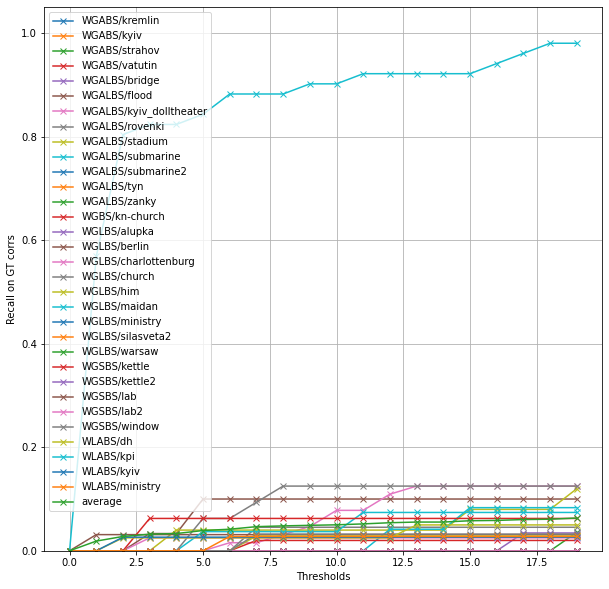

In [ ]:
plt.figure(figsize=(10,10))
plt.ylim([0,1.05])
plt.xlabel('Thresholds')
plt.ylabel('Recall on GT corrs')
plt.grid(True)


for img_pair, recall in result_dict.items():
    plt.plot(thresholds, recall, '-x', label=img_pair)

plt.legend()

### F-estimation benchmark results

I have evaluated several popular methods in this [Colab](https://colab.research.google.com/drive/1yrCFyEoAc0HyqYCRVvzJDh5kQT2Dc3XA?usp=sharing)

Here is the resulting graphs.
![image.png](index_files/att_00000.png)

If you are interested in adding your methods - open an issue.

## Task 2: finding the correspondence in image 2, given query point in image 1

Check this [Colab](https://colab.research.google.com/drive/1lfjU7N6kOB-bXEzJiUfiNXl24PwT_-FE?usp=sharing) 
for an example of running [COTR](https://github.com/ubc-vision/COTR) on for the correspondence estimation given the query points.

# Task 3: homography estimation on EVD

In [ ]:
import numpy as np
import cv2
import kornia.feature as KF
import kornia as K
import torch
from kornia_moons.feature import *
from tqdm import tqdm
from wxbs_benchmark.dataset import *
from wxbs_benchmark.evaluation import *
import matplotlib.pyplot as plt


def estimate_H_DISK_LG(img1, img2):
    device = torch.device('cpu')
    config = {"depth_confidence": -1, "width_confidence": -1}
    lg = KF.LightGlueMatcher("disk", config).to(device=device).eval()
    num_features = 2048
    disk = KF.DISK.from_pretrained("depth").to(device)
    timg1 = K.image_to_tensor(img1, False).float()
    if timg1.shape[1] == 1:
        timg1 = K.color.grayscale_to_rgb(timg1)
    timg1 = K.geometry.resize(timg1, (600, 800), antialias=True).to(device)
    timg2 = K.image_to_tensor(img2, False).float()
    if timg2.shape[1] == 1:
        timg2 = K.color.grayscale_to_rgb(timg2)
    timg2 = K.geometry.resize(timg2, (600, 800), antialias=True).to(device)
    
    features1 = disk(timg1, num_features, pad_if_not_divisible=True)[0]
    features2 = disk(timg2, num_features, pad_if_not_divisible=True)[0]
    
    kps1, descs1 = features1.keypoints, features1.descriptors
    kps2, descs2 = features2.keypoints, features2.descriptors

    lafs1 = KF.laf_from_center_scale_ori(kps1[None], 96 * torch.ones(1, len(kps1), 1, 1, device=device))
    lafs2 = KF.laf_from_center_scale_ori(kps2[None], 96 * torch.ones(1, len(kps2), 1, 1, device=device))
    dists, idxs = lg(descs1, descs2, lafs1, lafs2, hw1=timg1.shape[2:], hw2=timg2.shape[2:])
    #snn_ratio, idxs = KF.match_smnn(descs1, descs2, 0.98)
    idxs = idxs.detach().cpu().numpy()
    
    src_pts = kps1.detach().cpu().numpy()[idxs[:,0]].reshape(-1,2)
    src_pts[:, 0] *= (img1.shape[1] / float(timg1.shape[3]) )
    src_pts[:, 1] *= (img1.shape[0] / float(timg1.shape[2]) )

    dst_pts = kps2.detach().cpu().numpy()[idxs[:,1]].reshape(-1,2)
    dst_pts[:, 0] *= (img2.shape[1] / float(timg2.shape[3]) )
    dst_pts[:, 1] *= (img2.shape[0] / float(timg2.shape[2]) )
    try:
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
    except:
        H = np.eye(3)
    if H is None:
        H = np.eye(3)
    return H


Hs = []

dset = EVDDataset('.EVD',  download=True)
for pair_dict in tqdm(dset):
    with torch.inference_mode():
        Hs.append(estimate_H_DISK_LG(pair_dict['img1'],
                                     pair_dict['img2']))
        
result_dict, thresholds = evaluate_Hs(Hs)

  0%|                                                    | 0/15 [00:00<?, ?it/s]

Loaded LightGlue model


  7%|██▉                                         | 1/15 [00:01<00:26,  1.90s/it]

Loaded LightGlue model


 13%|█████▊                                      | 2/15 [00:03<00:23,  1.80s/it]

Loaded LightGlue model


 20%|████████▊                                   | 3/15 [00:05<00:20,  1.74s/it]

Loaded LightGlue model


 27%|███████████▋                                | 4/15 [00:07<00:19,  1.73s/it]

Loaded LightGlue model


 33%|██████████████▋                             | 5/15 [00:08<00:16,  1.66s/it]

Loaded LightGlue model


 40%|█████████████████▌                          | 6/15 [00:10<00:15,  1.72s/it]

Loaded LightGlue model


 47%|████████████████████▌                       | 7/15 [00:12<00:13,  1.69s/it]

Loaded LightGlue model


 53%|███████████████████████▍                    | 8/15 [00:13<00:11,  1.71s/it]

Loaded LightGlue model


 60%|██████████████████████████▍                 | 9/15 [00:15<00:10,  1.71s/it]

Loaded LightGlue model


 67%|████████████████████████████▋              | 10/15 [00:17<00:08,  1.71s/it]

Loaded LightGlue model


 73%|███████████████████████████████▌           | 11/15 [00:18<00:06,  1.65s/it]

Loaded LightGlue model


 80%|██████████████████████████████████▍        | 12/15 [00:20<00:05,  1.84s/it]

Loaded LightGlue model


 87%|█████████████████████████████████████▎     | 13/15 [00:22<00:03,  1.79s/it]

Loaded LightGlue model


 93%|████████████████████████████████████████▏  | 14/15 [00:24<00:01,  1.75s/it]

Loaded LightGlue model


100%|███████████████████████████████████████████| 15/15 [00:25<00:00,  1.73s/it]


Now plain DISK

In [ ]:
def estimate_H_DISK_smnn(img1, img2):
    device = torch.device('cpu')
    num_features = 2048
    disk = KF.DISK.from_pretrained("depth").to(device)
    timg1 = K.image_to_tensor(img1, False).float()
    if timg1.shape[1] == 1:
        timg1 = K.color.grayscale_to_rgb(timg1)
    timg1 = K.geometry.resize(timg1, (600, 800), antialias=True).to(device)
    timg2 = K.image_to_tensor(img2, False).float()
    if timg2.shape[1] == 1:
        timg2 = K.color.grayscale_to_rgb(timg2)
    timg2 = K.geometry.resize(timg2, (600, 800), antialias=True).to(device)
    
    features1 = disk(timg1, num_features, pad_if_not_divisible=True)[0]
    features2 = disk(timg2, num_features, pad_if_not_divisible=True)[0]
    
    kps1, descs1 = features1.keypoints, features1.descriptors
    kps2, descs2 = features2.keypoints, features2.descriptors

    dists, idxs = KF.match_smnn(descs1, descs2, 0.98)
    idxs = idxs.detach().cpu().numpy()
    
    src_pts = kps1.detach().cpu().numpy()[idxs[:,0]].reshape(-1,2)
    src_pts[:, 0] *= (img1.shape[1] / float(timg1.shape[3]) )
    src_pts[:, 1] *= (img1.shape[0] / float(timg1.shape[2]) )

    dst_pts = kps2.detach().cpu().numpy()[idxs[:,1]].reshape(-1,2)
    dst_pts[:, 0] *= (img2.shape[1] / float(timg2.shape[3]) )
    dst_pts[:, 1] *= (img2.shape[0] / float(timg2.shape[2]) )
    try:
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
    except:
        H = np.eye(3)
    if H is None:
        H = np.eye(3)
    return H


Hs_plain = []

dset = EVDDataset('.EVD',  download=True)
for pair_dict in tqdm(dset):
    with torch.inference_mode():
        Hs_plain.append(estimate_H_DISK_smnn(pair_dict['img1'],
                                     pair_dict['img2']))
        
result_dict_plain, thresholds = evaluate_Hs(Hs_plain)

100%|███████████████████████████████████████████| 15/15 [00:17<00:00,  1.16s/it]


<matplotlib.legend.Legend>

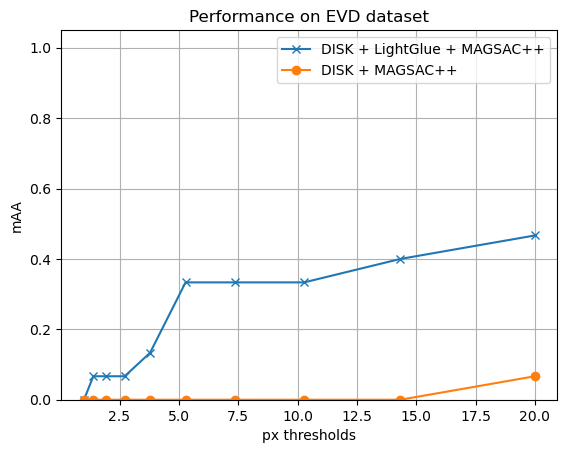

In [ ]:

plt.figure()
plt.plot(thresholds, result_dict['average'], '-x')
plt.plot(thresholds, result_dict_plain['average'], '-o')

plt.ylim([0,1.05])
plt.xlabel('px thresholds')
plt.ylabel('mAA')
plt.title('Performance on EVD dataset')
plt.grid(True)
plt.legend(['DISK + LightGlue + MAGSAC++', 'DISK + MAGSAC++'])
